# demo1 for partical=0

In [1]:
# import the necessary modules
import numpy as np
import random


# define the Lennard-Jones potential function
def LJ(r):
    # r: distance between two particles
    # return: potential energy between two particles
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

# define the Lennard-Jones force function
def LJ_force(r):
    # r: distance between two particles
    # return: force between two particles
    return -48 * epsilon * ((sigma / r) ** 13 - 0.5 * (sigma / r) ** 7)

# define the function to initialize the positions and velocities of the particles
def initialize():
    # return: pos, vel (initial positions and velocities of the particles)

    # initialize pos and vel as zero arrays
    pos = np.zeros((N, 2)) # pos[i] is the position vector of particle i
    vel = np.zeros((N, 2)) # vel[i] is the velocity vector of particle i

    # assign random positions to the particles in the middle region with no overlap
    n = 0 # number of assigned particles
    while n < N:
        x = random.uniform(1/3, 2/3) * L # random x coordinate in the middle region
        y = random.uniform(0, 1) * L # random y coordinate in the whole region
        r2min = np.min((pos[:n] - np.array([x, y])) ** 2, axis=1).sum() # minimum squared distance to other particles
        if n == 0 or r2min > sigma ** 2: # if no overlap
            pos[n] = np.array([x, y]) # assign position to particle n
            n += 1 # increase number of assigned particles

    # assign random velocities to the particles with zero center of mass velocity
    vel = np.random.randn(N, 2) # random velocity vectors from normal distribution
    vcm = vel.sum(axis=0) / N # center of mass velocity vector
    vel -= vcm # subtract center of mass velocity from each particle

    # return pos and vel
    return pos, vel

# define the function to update the positions and velocities of the particles using velocity Verlet algorithm
def update(pos, vel):
    # pos, vel: current positions and velocities of the particles
    # return: pos, vel (updated positions and velocities of the particles)

    # calculate the net force on each particle from Lennard-Jones potential
    force = np.zeros((N, 2)) # force[i] is the net force vector on particle i
    for i in range(N):
        for j in range(i + 1, N):
            rij = pos[i] - pos[j] # distance vector between particle i and j
            rij -= np.rint(rij / L) * L # apply periodic boundary condition
            r2 = rij ** 2 # squared distance between particle i and j
            fij = LJ_force(np.sqrt(r2)) * rij / np.sqrt(r2) # force vector between particle i and j from Lennard-Jones potential
            force[i] += fij # add force vector to net force on particle i
            force[j] -= fij # subtract force vector from net force on particle j

    # update positions and half-step velocities using velocity Verlet algorithm
    pos += vel * dt + 0.5 * force * dt ** 2 / m # update positions using current velocities and forces
    pos %= L # apply periodic boundary condition to positions
    vel += 0.5 * force * dt / m # update velocities by half-step using current forces

    # calculate the net force on each particle from Lennard-Jones potential at updated positions
    force = np.zeros((N, 2)) # force[i] is the net force vector on particle i
    for i in range(N):
        for j in range(i + 1, N):
            rij = pos[i] - pos[j] # distance vector between particle i and j
            rij -= np.rint(rij / L) * L # apply periodic boundary condition
            r2 = rij ** 2 # squared distance between particle i and j
            fij = LJ_force(np.sqrt(r2)) * rij / np.sqrt(r2) # force vector between particle i and j from Lennard-Jones potential
            force[i] += fij # add force vector to net force on particle i
            force[j] -= fij # subtract force vector from net force on particle j

    # update velocities by another half-step using updated forces
    vel += 0.5 * force * dt / m # update velocities using updated forces

    # return pos and vel
    return pos, vel

# define the function to simulate the motion and interaction of particles in the box
def simulate(n, p, t, dt):
    # n: initial number of particles in the middle region
    # p: probability of moving a particle from the middle region to either side
    # t: number of moves
    # dt: time step
    # return: positions, numbers (positions and numbers of particles in each region at each time step)

    # initialize positions and velocities of the particles
    pos, vel = initialize()

    # initialize numbers of particles in each region
    numbers = np.zeros((t + 1, 3), dtype=int) # numbers[i] is the number of particles in the left, middle and right region at time step i
    numbers[0, 1] = n # initial number of particles in the middle region

    # initialize positions of particles at each time step
    positions = [pos.copy()] # positions[i] is the position array of particles at time step i

    # loop for t times
    for i in range(t):
        # randomly choose a direction (left or right) and move a particle from the middle region to that direction with probability p
        direction = random.choice(["left", "right"])
        if random.random() < p:
            # find the indices of the particles in the middle region
            indices = np.where((pos[:, 0] > L / 3) & (pos[:, 0] < 2 * L / 3))[0]
            if len(indices) > 0: # if there are particles in the middle region
                # randomly choose one particle from the middle region
                index = random.choice(indices)
                # move it to the chosen direction by changing its x coordinate
                if direction == "left":
                    pos[index, 0] -= L / 3
                else:
                    pos[index, 0] += L / 3

        # randomly move a particle from the left or right region to the middle region with probability p
        for side in ["left", "right"]:
            if random.random() < p:
                # find the indices of the particles in the left or right region
                if side == "left":
                    indices = np.where(pos[:, 0] < L / 3)[0]
                else:
                    indices = np.where(pos[:, 0] > 2 * L / 3)[0]
                if len(indices) > 0: # if there are particles in the left or right region
                    # randomly choose one particle from the left or right region
                    index = random.choice(indices)
                    # move it to the middle region by changing its x coordinate
                    if side == "left":
                        pos[index, 0] += L / 3
                    else:
                        pos[index, 0] -= L / 3

        # update positions and velocities of the particles using velocity Verlet algorithm
        pos, vel = update(pos, vel)

        # update numbers of particles in each region by counting the x coordinates of the particles
        numbers[i + 1, 0] = np.count_nonzero(pos[:, 0] < L / 3) # number of particles in the left region
        numbers[i + 1, 1] = np.count_nonzero((pos[:, 0] > L / 3) & (pos[:, 0] < 2 * L / 3)) # number of particles in the middle region
        numbers[i + 1, 2] = np.count_nonzero(pos[:, 0] > 2 * L / 3) # number of particles in the right region

        # append positions of particles at this time step to the list
        positions.append(pos.copy())

    # return positions and numbers
    return positions, numbers

In [2]:
# Example_1_define the parameters
N = 270 # number of particles
p = 0.5 # probability of moving a particle
t = 100 # number of moves
dt = 0.1 # time step
L = 1.0 # length of the box
m = 1.0 # mass of a particle
sigma = 0.12 # length parameter of the Lennard-Jones potential
epsilon = 1.0 # energy parameter of the Lennard-Jones potential

# example: simulate with n = 270, p = 0.5, t = 200, dt = 0.01
# 2example: simulate with n = 270, p = 0.5, t = 100, dt = 0.1
positions, numbers = simulate(N, p, t, dt)
print(f"Positions of particles at each time step: {positions}")
print(f"Numbers of particles in each region at each time step: {numbers}")

/tmp/ipykernel_3591/1993877355.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return -48 * epsilon * ((sigma / r) ** 13 - 0.5 * (sigma / r) ** 7)
/tmp/ipykernel_3591/1993877355.py:16: RuntimeWarning: invalid value encountered in subtract
  return -48 * epsilon * ((sigma / r) ** 13 - 0.5 * (sigma / r) ** 7)


Positions of particles at each time step: [array([[0.61450477, 0.64760245],
       [0.44339912, 0.09578408],
       [0.6212803 , 0.76423267],
       [0.6204696 , 0.4239247 ],
       [0.62835202, 0.49760298],
       [0.56188961, 0.13246883],
       [0.43046824, 0.77438961],
       [0.48372276, 0.82213969],
       [0.45463099, 0.39506297],
       [0.577799  , 0.7106233 ],
       [0.55992129, 0.27000072],
       [0.34673421, 0.92460538],
       [0.43407124, 0.46570205],
       [0.57861977, 0.4426504 ],
       [0.35582498, 0.1907263 ],
       [0.53040919, 0.50301502],
       [0.43622198, 0.5082831 ],
       [0.35768845, 0.38158734],
       [0.44118765, 0.02976628],
       [0.58951396, 0.07590196],
       [0.44146067, 0.65104382],
       [0.50974295, 0.99309582],
       [0.63064468, 0.504126  ],
       [0.48668261, 0.79605339],
       [0.60965369, 0.93476308],
       [0.39704661, 0.23711301],
       [0.55227868, 0.99762315],
       [0.40545573, 0.14853662],
       [0.5575737 , 0.47862362],


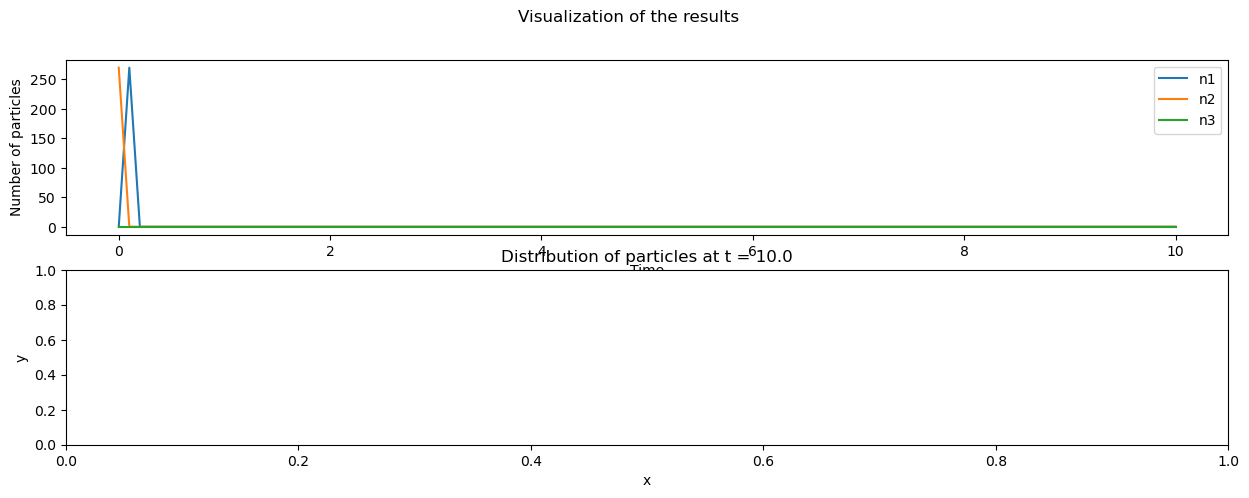

In [3]:
# Visible_N=270 Example_1
import matplotlib.pyplot as plt

# create a figure and two subplots for plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
fig.suptitle("Visualization of the results") # set the figure title

# plot the numbers of particles in each region as a function of time on the left subplot
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 0], label="n1") # plot n1
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 1], label="n2") # plot n2
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 2], label="n3") # plot n3
ax1.set_xlabel("Time") # set the x-axis label
ax1.set_ylabel("Number of particles") # set the y-axis label
ax1.legend() # show the legend

# plot the distribution of particles in each region at the final time step on the right subplot
ax2.scatter(positions[-1][:, 0], positions[-1][:, 1], c="blue") # plot the positions of particles
ax2.set_xlim(0, 1) # set the x-axis limit
ax2.set_ylim(0, 1) # set the y-axis limit
ax2.set_xlabel("x") # set the x-axis label
ax2.set_ylabel("y") # set the y-axis label
ax2.set_title(f"Distribution of particles at t = {t * dt}") # set the title

# show the figure
plt.show()

# demo2 for visible

## example2 N=6

In [ ]:
# Visible_N=6 Example_2
import matplotlib.pyplot as plt

# create a figure and two subplots for plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
fig.suptitle("Visualization of the results") # set the figure title

# plot the numbers of particles in each region as a function of time on the left subplot
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 0], label="n1") # plot n1
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 1], label="n2") # plot n2
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 2], label="n3") # plot n3
ax1.set_xlabel("Time") # set the x-axis label
ax1.set_ylabel("Number of particles") # set the y-axis label
ax1.legend() # show the legend

# plot the distribution of particles in each region at the final time step on the right subplot
ax2.scatter(positions[-1][:, 0], positions[-1][:, 1], c="blue") # plot the positions of particles
ax2.set_xlim(0, 1) # set the x-axis limit
ax2.set_ylim(0, 1) # set the y-axis limit
ax2.set_xlabel("x") # set the x-axis label
ax2.set_ylabel("y") # set the y-axis label
ax2.set_title(f"Distribution of particles at t = {t * dt}") # set the title

# show the figure
plt.show()

## example1 N=270

In [ ]:
# Visible_N=270 Example_1
import matplotlib.pyplot as plt

# create a figure and two subplots for plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
fig.suptitle("Visualization of the results") # set the figure title

# plot the numbers of particles in each region as a function of time on the left subplot
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 0], label="n1") # plot n1
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 1], label="n2") # plot n2
ax1.plot([i * dt for i in range(t + 1)], numbers[:, 2], label="n3") # plot n3
ax1.set_xlabel("Time") # set the x-axis label
ax1.set_ylabel("Number of particles") # set the y-axis label
ax1.legend() # show the legend

# plot the distribution of particles in each region at the final time step on the right subplot
ax2.scatter(positions[-1][:, 0], positions[-1][:, 1], c="blue") # plot the positions of particles
ax2.set_xlim(0, 1) # set the x-axis limit
ax2.set_ylim(0, 1) # set the y-axis limit
ax2.set_xlabel("x") # set the x-axis label
ax2.set_ylabel("y") # set the y-axis label
ax2.set_title(f"Distribution of particles at t = {t * dt}") # set the title

# show the figure
plt.show()